Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [53]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

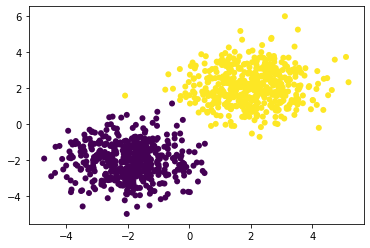

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

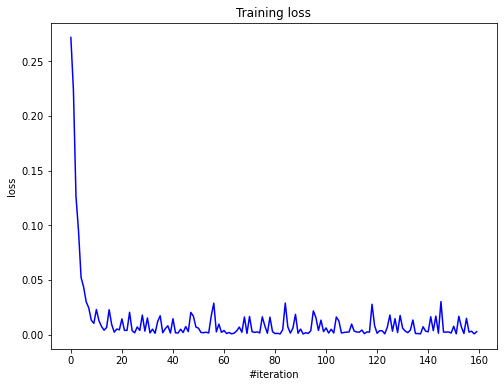

Current loss: 0.002653


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [137]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [138]:
# Your code goes here. ################################################
import torch
import numpy as np

def one_hot_encode(x):
    encoded = np.zeros((x.size, x.max()+1))
    encoded[np.arange(x.size), x] = 1
    return encoded

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

In [139]:
X_train.shape

(50000, 28, 28)

In [140]:
X_train = X_train.reshape(-1,28*28)
X_val = X_val.reshape(-1,28*28)
X_test = X_test.reshape(-1,28*28)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [122]:
# Your code goes here. ################################################

# Looping params
n_epoch = 10
batch_size = 20

activation_list = [ReLU, ELU, LeakyReLU, SoftPlus]

criterion = ClassNLLCriterion()

# Optimizer params
optimizer_list = [sgd_momentum, adam_optimizer]
optimizer_config_dict = {}
optimizer_state_dict = {}
optimizer_config_dict["sgd_momentum"] = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_config_dict["adam_optimizer"] = {'learning_rate' : 0.001, "beta1" : 0.9, "beta2" : 0.999, "epsilon" : 1e-08}
optimizer_state_dict["sgd_momentum"] = {}
optimizer_state_dict["adam_optimizer"] = {}

# Building Nets
net_list = []

for Activation in activation_list:
    net = Sequential()
    net.add(Linear(28*28, 512))
    net.add(ChannelwiseScaling(512))
    net.add(BatchNormalization(alpha=0.1))
    net.add(Activation())
    net.add(Dropout())
    net.add(Linear(512, 512))
    net.add(ChannelwiseScaling(512))
    net.add(BatchNormalization(alpha=0.1))
    net.add(Activation())
    net.add(Dropout())
    net.add(Linear(512, 10))
    net.add(LogSoftMax())
    net_list.append(net)

print(net_list[0])

Linear 784 -> 512
ChannelwiseScaling
BatchNormalization
ReLU
Dropout
Linear 512 -> 512
ChannelwiseScaling
BatchNormalization
ReLU
Dropout
Linear 512 -> 10
LogSoftMax



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Current optimizer: sgd_momentum


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Final loss for sgd_momentum and activation ReLU: 0.2176737807669596


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Final loss for sgd_momentum and activation ELU: 0.0032206155691910008


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Final loss for sgd_momentum and activation LeakyReLU: 0.1334239557066376


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Final loss for sgd_momentum and activation SoftPlus: 1.2508741259283869
Current optimizer: adam_optimizer


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Final loss for adam_optimizer and activation ReLU: 1.3248502833608908


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Final loss for adam_optimizer and activation ELU: 0.4271312308264255


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Final loss for adam_optimizer and activation LeakyReLU: 0.9220136153015892


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:39<00:00, 81.99s/it]


Final loss for adam_optimizer and activation SoftPlus: 4.478618594985153


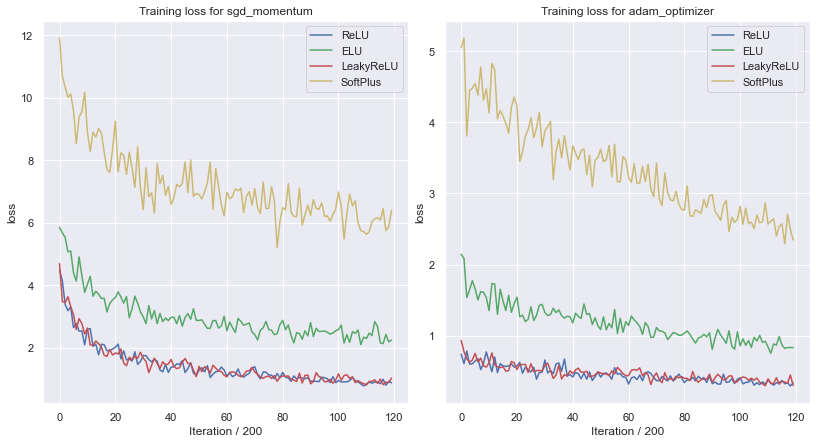

In [123]:
# Training
from tqdm import tqdm
import seaborn as sns
sns.set()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.tight_layout()
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1, hspace = 0.3)

for j, optimizer in enumerate(optimizer_list):
    loss_history_dict = {
        ReLU : [],
        ELU : [],
        LeakyReLU : [],
        SoftPlus :[]
    }
    print(f"Current optimizer: {optimizer.__name__}")
    
    for i, (custom_net, key) in enumerate(zip(net_list, loss_history_dict)):
        final_loss = 0.0
        for epoch in tqdm(range(n_epoch)):
            running_loss = 0.0
            for i, data_batch in enumerate(get_batches((X_train, y_train), batch_size)):
                x_batch, y_batch = data_batch
                custom_net.zeroGradParameters()
                
                # Forward
                predictions = custom_net.forward(x_batch)
                loss = criterion.forward(predictions, y_batch)
            
                # Backward
                dp = criterion.backward(predictions, y_batch)
                custom_net.backward(x_batch, dp)
                
                # Update weights
                optimizer(custom_net.getParameters(), 
                             custom_net.getGradParameters(), 
                             optimizer_config_dict[optimizer.__name__],
                             optimizer_state_dict[optimizer.__name__])      
                
                running_loss += loss
                final_loss = loss
                if i % 200 == 199:
                    loss_history_dict[key].append(running_loss/200)
                    running_loss = 0.0
                    
        print(f"Final loss for {optimizer.__name__} and activation {key.__name__}: {final_loss}")
        
    ax[j].set_title(f"Training loss for {optimizer.__name__}")
    ax[j].set_xlabel("Iteration / 200")
    ax[j].set_ylabel("loss")
    ax[j].plot(loss_history_dict[ReLU], 'b', label="ReLU")
    ax[j].plot(loss_history_dict[ELU], 'g', label="ELU")
    ax[j].plot(loss_history_dict[LeakyReLU], 'r', label = "LeakyReLU")
    ax[j].plot(loss_history_dict[SoftPlus], 'y', label = "SoftPlus")
    ax[j].legend(); 

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [25]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [141]:
# Your code goes here. ################################################

""" Now let's do everything at once and efficiently with validation and testing. """

# Looping params
n_epoch = 10
batch_size = 20

# Logloss
criterion = ClassNLLCriterion()

# Optimizer parameters
adam_optimizer_state = {}
adam_optimizer_config = {'learning_rate' : 0.001, "beta1" : 0.9, "beta2" : 0.999, "epsilon" : 1e-08}

model = Sequential()
model.add(Linear(28*28, 512))
model.add(ChannelwiseScaling(512))
model.add(BatchNormalization(alpha=0.1))
model.add(ReLU())
model.add(Dropout())
model.add(Linear(512, 512))
model.add(ChannelwiseScaling(512))
model.add(BatchNormalization(alpha=0.1))
model.add(ReLU())
model.add(Dropout())
model.add(Linear(512, 10))
model.add(LogSoftMax())

print(model)

Linear 784 -> 512
ChannelwiseScaling
BatchNormalization
ReLU
Dropout
Linear 512 -> 512
ChannelwiseScaling
BatchNormalization
ReLU
Dropout
Linear 512 -> 10
LogSoftMax



In [186]:
train_loss_history = []
val_loss_history = []

for epoch in tqdm(range(n_epoch)):
    ###################
    # train the model #
    ###################
    running_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(get_batches((X_train, y_train), batch_size)):
        model.zeroGradParameters()
        
        # Forward
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(model.getParameters(), 
                     model.getGradParameters(), 
                     adam_optimizer_config,
                     adam_optimizer_state)      
        
        running_loss += loss
        if i % 200 == 199:
            train_loss_history.append(running_loss / 200)
            running_loss = 0.0
            
    ######################
    # validate the model #
    ######################
    running_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(get_batches((X_val, y_val), batch_size)):
        prediction = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        running_loss += loss
        if i % 200 == 199:
            val_loss_history.append(running_loss / 200)
            running_loss = 0.0 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:04<00:00, 78.49s/it]


Print here your accuracy on test set. It should be around 90%.

In [185]:
# Your answer goes here. ################################################
test_loss_history = []
running_loss = 0.0

correct = 0
total = 0
for i, (x_batch, y_batch) in enumerate(get_batches((X_test, y_test), batch_size)):
    prediction = model.forward(x_batch)
    
    loss = criterion.forward(predictions, y_batch)
    running_loss += loss
    
    mask = np.argmax(prediction, axis=1) == np.argmax(y_batch, axis=1)
    total = len(mask)
    correct = mask.sum()
    
    if i % 200 == 199:
        test_loss_history.append(running_loss / 200)
        running_loss = 0.0

print(f"Accuracy for whole test data: {correct / total}")

Accuracy for whole test data: 0.95


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [125]:
# Your beautiful code here.
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [126]:
# Number of subprocesses to use for data loading
num_workers = 0

batch_size = 20
# Percentage of training set to use as validation
valid_size = 0.2

# Convert data to torch.FloatTensor
transform = transforms.ToTensor()

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

In [127]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([20, 1, 28, 28])

In [128]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,10)
        self.dropout = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(512)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = self.batchnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batchnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [129]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [130]:
n_epochs = 50
valid_loss_min = np.Inf  

for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        
        # Forward
        output = model(data)
        loss = criterion(output,label)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data,label in valid_loader:
        # Forward
        output = model(data)
        loss = criterion(output,label)
        
        valid_loss = loss.item() * data.size(0)
    
    # Print training/validation statistics 
    # Calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.363423 	Validation Loss: 0.000510
Validation loss decreased (inf --> 0.000510).  Saving model ...
Epoch: 2 	Training Loss: 0.190459 	Validation Loss: 0.000211
Validation loss decreased (0.000510 --> 0.000211).  Saving model ...
Epoch: 3 	Training Loss: 0.145041 	Validation Loss: 0.000303
Epoch: 4 	Training Loss: 0.124429 	Validation Loss: 0.000390
Epoch: 5 	Training Loss: 0.106546 	Validation Loss: 0.000072
Validation loss decreased (0.000211 --> 0.000072).  Saving model ...
Epoch: 6 	Training Loss: 0.096377 	Validation Loss: 0.000228
Epoch: 7 	Training Loss: 0.088973 	Validation Loss: 0.000260
Epoch: 8 	Training Loss: 0.078173 	Validation Loss: 0.000048
Validation loss decreased (0.000072 --> 0.000048).  Saving model ...
Epoch: 9 	Training Loss: 0.075358 	Validation Loss: 0.000179
Epoch: 10 	Training Loss: 0.070203 	Validation Loss: 0.000219
Epoch: 11 	Training Loss: 0.065141 	Validation Loss: 0.000181
Epoch: 12 	Training Loss: 0.060772 	Validation Loss: 0.0

In [131]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [132]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
    # Forward
    output = model(data)
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # Calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# Calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.116874

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 97% (1105/1135)
Test Accuracy of     2: 93% (962/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 95% (933/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 95% (913/958)
Test Accuracy of     7: 98% (1008/1028)
Test Accuracy of     8: 94% (925/974)
Test Accuracy of     9: 96% (978/1009)

Test Accuracy (Overall): 96% (9666/10000)


<ipython-input-133-acd2d4788295>:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


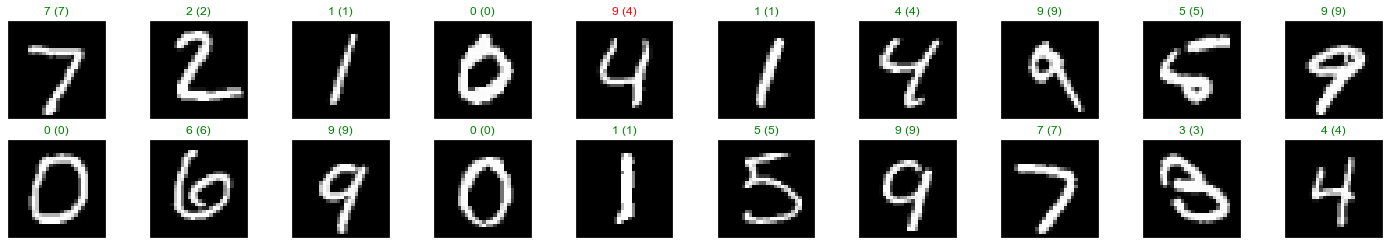

In [133]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
# Convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# Prep images for display
images = images.numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))